This script is a simple implementation of a simulation of the possible range of motion of a robot arm. 

In [1]:
import numpy as np 
from numpy import sin, cos, tan
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class angle_range:
    def __init__(self, lower_range, upper_range, angle_step=1):
        self.lower_range = lower_range
        self.upper_range = upper_range
        self.angle_step = angle_step
        self.range = np.arange(lower_range, (upper_range+1), angle_step)

    def __call__(self):
        return self.range

yaw_rom = angle_range(-30, 30) #left/right rotation
pitch_rom = angle_range(-20, 20) #neck lateral bending
roll_rom = angle_range(-15, 15) #neck extension/ flexion

implant_radius = 100.0 #mm
centre = 0.0

In [3]:
class Vector:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.vector = np.array([[self.x], [self.y], [self.z]])
    
    def __mul__(self, other):
        if isinstance(other, Vector):
            return self.vector@other.vector
        else:
            return self.vector*other
    
    def __add__(self, other):
        if isinstance(other, Vector):
            return self.vector+other.vector
        else:
            return self.vector+other

    def __radd__(self, other):
        return other+self.vector

    def __rmul__(self, other):
        return other*self.vector


In [4]:
class rotation_matrix:
    def __init__(self, n_dimensions: int, yaw: float = 0.0, pitch: float = 0.0, roll: float = 0.0):
        self.n_dimensions = n_dimensions
        self.yaw = yaw
        self.pitch = pitch
        self.roll = roll
        
        match n_dimensions:
            case 2:
                self.rotation_matrix = np.array([[cos(yaw), -sin(yaw)], [sin(yaw), cos(yaw)]])
            case 3:
                self.yaw_matrix = np.array([[cos(yaw), -sin(yaw), 0], [sin(yaw), cos(yaw), 0], [0, 0, 1]])
                self.pitch_matrix = np.array([[cos(pitch), 0, sin(pitch)], [0, 1, 0], [-sin(pitch), 0, cos(pitch)]])
                self.roll_matrix = np.array([[1, 0, 0], [0, cos(roll), -sin(roll)], [0, sin(roll), cos(roll)]])
                self.rotation_matrix = self.yaw_matrix @ self.pitch_matrix @ self.roll_matrix
    
    def transpose(self):
        return np.transpose(self.rotation_matrix)

    def inverse(self):
        return np.transpose(self.rotation_matrix)
    
    def __mul__(self, other):
        if isinstance(other, rotation_matrix):
            return self.rotation_matrix @ other.rotation_matrix
        
        elif isinstance(other, Vector):
            return self.rotation_matrix @ other.vector
        else:
            return self.rotation_matrix * other
    
    def __rmul__(self, other):
        if isinstance(other, Vector):
            return other.vector @ self.rotation_matrix
        elif not isinstance(other, rotation_matrix):
            return other * self.rotation_matrix
    
    def __add__(self, other):
        """ Note that to add or subtract matrices they have to be of the same size
        """
        if isinstance(other, rotation_matrix):
            try:
                return self.rotation_matrix + other.rotation_matrix
            except ValueError:
                return "Operation is not possible check the sizes of the matrices"

    def __repr__(self):
        return self.rotation_matrix
    
    


In [7]:
ROM_points = []

start_vector = Vector(0.0, implant_radius, 0.0)


for yaw_angle in yaw_rom.range:
    for pitch_angle in pitch_rom.range:
        for roll_angle in roll_rom.range:
            ro_matrix = rotation_matrix(3, yaw_angle, pitch_angle, roll_angle)
            new_vector = ro_matrix*start_vector
            ROM_points.append(new_vector)
            
workspace_points = np.array(ROM_points)

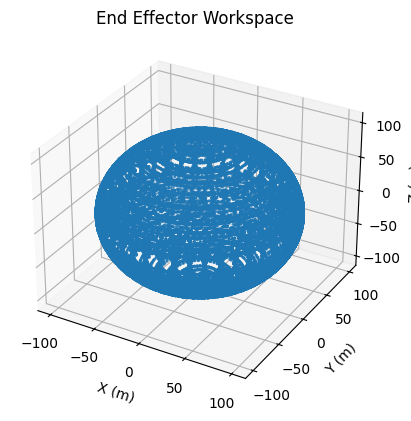

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(workspace_points[:, 0], workspace_points[:, 1], workspace_points[:, 2], s=1)
ax.set_title('End Effector Workspace')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
plt.show()